In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import torch
import torchvision
import csgm
import dcgan
import skimage
import anchor_image
import image_utils

In [2]:
mnist_test = torchvision.datasets.MNIST('./', train=False, transform=lambda x: np.array(x)/255.,
                                   target_transform=None, download=True)

In [3]:
dataload = torch.utils.data.DataLoader(mnist_test,batch_size = 32)

### Load Classification Model

In [4]:
net = dcgan.Net()
net.load_state_dict(torch.load('mnist_cnn.pt'))

In [5]:
def predict_fn(images):
    try:
        images = torch.from_numpy(images).type(torch.FloatTensor)
    except:
        pass
    return net(images.view(images.shape[0],1,28,28)).data.numpy()

### Load GAN

In [6]:
G = dcgan.load_generator().cuda()

### Load Image and Test Segmentation Parameters

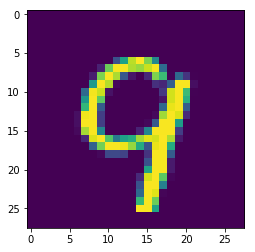

In [7]:
image = mnist_test[16][0]
plt.imshow(image)

3 32
4.133333333333333 12
3.9333333333333327 13
3.7999999999999994 13
found max_dist of  3.666666666666666  created 10 segments


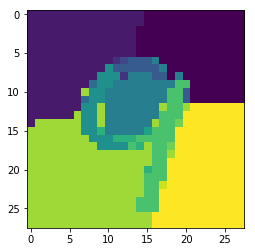

In [8]:
img = np.repeat(image[:,:,np.newaxis],3,2)
plt.imshow(image_utils.create_segments(image))

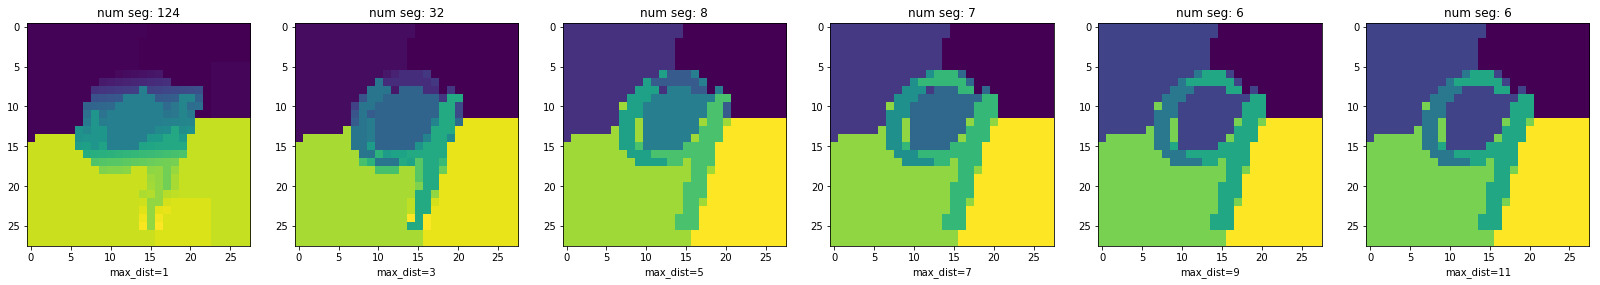

In [9]:
fig, ax = plt.subplots(1,6,figsize = (28,28))
img = np.repeat(image[:,:,np.newaxis],3,2)
for i in range(1,12,2):
    seg = skimage.segmentation.quickshift(img, kernel_size=2, max_dist=i, ratio=0.2)
    ax[i//2].set_title('num seg: {}'.format(len(np.unique(seg))))
    ax[i//2].set(xlabel='max_dist='+str(i))
    ax[i//2].imshow(seg)

Text(0,0.5,'num segments')

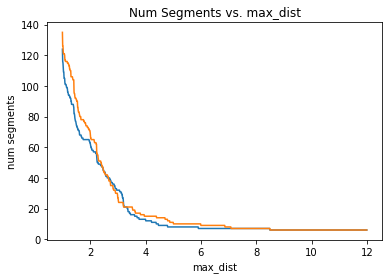

In [10]:
img = np.repeat(image[:,:,np.newaxis],3,2)
seg_num1 = []
x_ran1 = []
seg_num2 = []
x_ran2 = []

for i in np.arange(1,12,.01):
    seg = skimage.segmentation.quickshift(img, kernel_size=2, max_dist=i, ratio=0.2)
    seg_num1.append(len(np.unique(seg)))
    x_ran1.append(i)
    
imag = mnist_test[54][0]
img = np.repeat(imag[:,:,np.newaxis],3,2)
for i in np.arange(1,12,.01):
    seg = skimage.segmentation.quickshift(img, kernel_size=2, max_dist=i, ratio=0.2)
    seg_num2.append(len(np.unique(seg)))
    x_ran2.append(i)

plt.plot(x_ran1, seg_num1)
plt.plot(x_ran2, seg_num2)
plt.title('Num Segments vs. max_dist')
plt.xlabel('max_dist')
plt.ylabel('num segments')

## Anchor Explanations

In [11]:
explainer = anchor_image.AnchorImageMNIST([], 'yeet',
                               G=G, dataset = mnist_test)

In [ ]:
%%time
segments, exp = explainer.explain_instance(image,predict_fn,verbose=True)

3 32
4.133333333333333 12
3.9333333333333327 13
3.7999999999999994 13
found max_dist of  3.666666666666666  created 10 segments
True pred 9
100
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Best: 7 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 0 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
100
100
Best: 5 (mean:1.0000000000, n: 1, lb:0.0000) Worst: 1 (mean:0.0000, n: 1, ub:1.0000) B = 1.00
100
100
Best: 7 (mean:0.3069306931, n: 101, lb:0.1079) Worst: 2 (mean:0.0000, n: 1, ub:1.0000) B = 0.89
100
100
Best: 7 (mean:0.3532338308, n: 201, lb:0.1886) Worst: 3 (mean:0.0000, n: 1, ub:1.0000) B = 0.81
100
100
Best: 7 (mean:0.3853820598, n: 301, lb:0.2414) Worst: 4 (mean:0.0000, n: 1, ub:1.0000) B = 0.76
100
100
Best: 7 (mean:0.4064837905, n: 401, lb:0.2770) Worst: 6 (mean:0.0000, n: 1, ub:1.0000) B = 0.72
100
100
Best: 7 (mean:0.4111776447, n: 501, lb:0.2934) Worst: 8 (mean:0.0000, n: 1, ub:1.0000) B = 0.71
100
100
Best: 7 (mean:0.4093178037, n: 601, lb:0.3008) Worst: 9 (mean:0.0000, n: 1, ub:1.0000) B = 0.70
100


In [ ]:
exp

In [ ]:
exp_ = {}
exp_['feature']=[i[0] for i in exp]
_,mask = image_utils.create_mask(image,segments,exp_)

In [ ]:
anchored = mask*((image-0.5)*2)
# final = (1-mask)* + target

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (12,12))
[ax[i].set_axis_off() for i in range(3)]
ax[0].imshow((image-0.5)*2, vmin=-1,vmax=1)
ax[0].set_title('Original Image')
ax[1].imshow(segments)
ax[1].set_title('Segmentation Map')
ax[2].imshow(anchored,vmin=-1, vmax=1)
ax[2].set_title('Anchored Image')
# ax[1].imshow(final,vmin=-1, vmax=1)
# plt.axis('off');

## Examples of Generated G(z | A)

In [ ]:
target = mask*((image-0.5)*2)

In [ ]:
# batch_target = np.repeat(target[np.newaxis,:,:],10,axis=0)
raw_reconstruct,background = csgm.reconstruct_batch(target, mask, np.sum(mask), G, 10)

In [ ]:
plt.imshow(raw_reconstruct[2])

In [ ]:
plt.figure(figsize=(10,10))
ax = [plt.subplot(4,4,i+1) for i in range(8)]
plt.subplots_adjust(wspace=0, hspace=0.1);
[ax[i].set_axis_off() for i in range(8)]
ax[0].imshow(raw_reconstruct[2])
ax[1].imshow(raw_reconstruct[4])
ax[2].imshow(raw_reconstruct[6])
ax[3].imshow(raw_reconstruct[7])
ax[4].imshow(background[2] + target)
ax[5].imshow(background[4] + target)
ax[6].imshow(background[6] + target)
ax[7].imshow(background[7] + target)

In [ ]:
predict_fn(background+target).argmax(1)